# Reproduction of results from "A polynomial-time approximation to optimal multivariate microaggregation"

Domingo-Ferrer, Josep, Francesc Sebé, and Agusti Solanas. ‘A Polynomial-Time Approximation to Optimal Multivariate Microaggregation’. Computers & Mathematics with Applications 55, no. 4 (1 February 2008): 714–32. https://doi.org/10.1016/j.camwa.2007.04.034.


In [1]:
import numpy as np
from itertools import chain

In [2]:
from microagg1d.multivariate_poly import *

In [3]:
import pandas as pd
from tqdm.notebook import tqdm

In [4]:
records = [
["A&A Ltd " ,790 ,55 ,3212334 ,313250],
["B&B SpA " ,710 ,44 ,2283340 ,299876],
["C&C Inc " ,730 ,32 ,1989233 ,200213],
["D&D BV  " ,810 ,17 ,984983  ,143211],
["E&E SL  " ,950 ,3  ,194232  ,51233],
["F&F GmbH" ,510 ,25 ,119332  ,20333],
["G&G AG  " ,400 ,45 ,3012444 ,501233],
["H&H SA  " ,330 ,50 ,4233312 ,777882],
["I&I LLC " ,510 ,5  ,159999  ,60388 ],
["J&J Co  " ,760 ,52 ,5333442 ,1001233],
["K&K Sarl" ,50  ,12 ,645223  ,333010],]

In [5]:
df = pd.DataFrame.from_records(records, columns=["name", "surface", "employees", "turnover", "profit"])

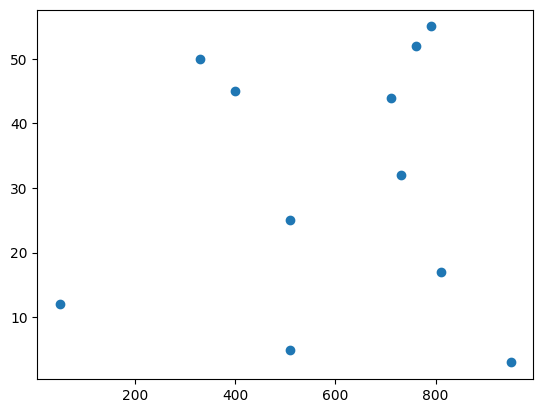

In [6]:
import matplotlib.pyplot as plt
plt.scatter(df.surface, df.employees)

In [7]:
def permutate_closest_neighbors(closest_neighbors):
    k = closest_neighbors.shape[1]
    for i in range(closest_neighbors.shape[0]):
        closest_neighbors[i,:]=closest_neighbors[i,:][np.random.permutation(k)]

In [8]:
def apply_basic(df, k):
    if isinstance(df, pd.DataFrame):
        arr = df.to_numpy()
    else:
        arr = df
    # print(arr)
    dists = compute_dists(arr)
    # print(dists)
    closest_neighbors = get_k_closest(dists, k)
    permutate_closest_neighbors(closest_neighbors)
    # print(closest_neighbors)
    components, edges = forest2(closest_neighbors)
    return components, edges

In [9]:
from tqdm.notebook import tqdm

## Find seed that matches the given example

In [10]:
from sklearn import preprocessing
df_in = preprocessing.StandardScaler().fit_transform(df[[ "surface", "employees"]])
# df_in = df[[ "surface", "employees"]]
for seed in tqdm(range(650_000, 1_000_000)):
    set_both_seeds(seed)
    components, edges = apply_basic(df_in, 3)
    s = set(map(tuple, edges))
    if all(x in s for x in [(6,7), (3,4), (2,3), (8,5), (10,8), (7,5), (5,2), (1,2), (0,9), (9,1)]):
        print(seed)
        print(edges)
        break

  0%|          | 0/350000 [00:00<?, ?it/s]

658143
[[ 6  7]
 [ 0  9]
 [ 3  4]
 [ 2  3]
 [ 5  2]
 [ 1  2]
 [ 7  5]
 [ 9  1]
 [ 8  5]
 [10  8]]


## Plot the found example to check that it agrees with the paper

In [11]:
# assign positions to the nodes
df_in = preprocessing.StandardScaler().fit_transform(df[[ "surface", "employees"]])
pos = {}
for i in range(len(df)):
    pos[i] = (df_in[i,0], df_in[i,1])

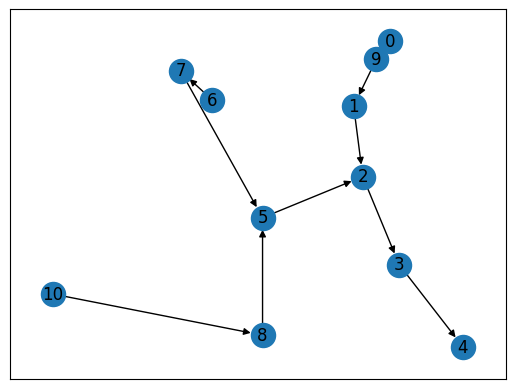

In [12]:
import networkx as nx

seed=658143 # magical seed that procudes the example in the paper :)
set_both_seeds(seed)
components, edges = apply_basic(df_in, 3)

G = nx.DiGraph()
G.add_nodes_from(df.index)
G.add_edges_from(edges)
plt.figure()
nx.draw_networkx(G, pos = pos)
plt.scatter(df_in[:,0], df_in[:,1])
plt.draw()

## In the following we test the decompose components procedure

The suggestes algorithm works by first creating a tree and then decomposing the tree into smaller and smaller components

### Test some random seed

In [13]:

seed = 25
set_both_seeds(seed)
result = decompose_components(components, edges, 3, len(df))
print(result)
for steiner, comp in result:
    print(list(map(int, steiner)), list(map(int, comp)))
for steiner, comp in result:
    assert len(set(comp)-set(steiner))>=3, seed
comps = [comp for steiner, comp in result]
assert len(set(chain.from_iterable(comps)))==11 
if len(result)>2:
    print(seed)
    for steiner, comp in result:
        print(list(map(int, steiner)), list(map(int, comp)))

[(ListType[int64]([, ...]), array([ 5,  8, 10], dtype=int64)), (ListType[int64]([, ...]), array([1, 9, 0], dtype=int64)), (ListType[int64]([5, 1, ...]), array([1, 2, 3, 5, 7, 6, 4], dtype=int64)), ...]
[] [5, 8, 10]
[] [1, 9, 0]
[5, 1] [1, 2, 3, 5, 7, 6, 4]
25
[] [5, 8, 10]
[] [1, 9, 0]
[5, 1] [1, 2, 3, 5, 7, 6, 4]


### Run randomized tests

In [14]:
if True:
    for seed in tqdm(range(1_000_000)):
        set_both_seeds(seed)
        result = decompose_components(components, edges, 3, len(df))
        for steiner, comp in result:
            assert len(set(comp)-set(steiner))>=3, seed
        comps = [comp for steiner, comp in result]
        assert len(set(chain.from_iterable(comps)))==11

### Find seed that agrees with the given example

In [15]:
target_result = set([frozenset([0,9,1]), frozenset([2,3,4]), frozenset([6,7,5,8,10])])

In [16]:
if True:
    for seed in tqdm(range(4, 1_000_000)):
        set_both_seeds(seed)
        result = decompose_components(components, edges, 3, len(df))
        for steiner, comp in result:
            assert len(set(comp)-set(steiner))>=3, seed
        comps = [comp for steiner, comp in result]
        assert len(set(chain.from_iterable(comps)))==11
        if len(result)>2:
            this_set = set()
            for steiner, comp in result:
                this_set.add(frozenset(list(map(int, comp))))
            if target_result == this_set:
                print("seed:", seed)
                for steiner, comp in result:
                    print(list(map(int, steiner)), list(map(int, comp)))
                break

In [24]:
if True:
    k = 5
    for seed in tqdm(range(1_000_000)):
        set_both_seeds(seed)
        result = decompose_components(components, edges, k, len(df), False)
        for steiner, comp in result:
            assert len(set(comp))>=k, (seed, comp)
            assert len(set(comp)) <= max(2*k - 1, 3*k - 5), len(set(comp))
            if len(comp)>=2*k:
                print(seed)
        comps = [comp for steiner, comp in result]
        assert len(set(chain.from_iterable(comps)))==11

  0%|          | 0/1000000 [00:00<?, ?it/s]